In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, mean_squared_error

In [3]:
# Define image dimensions for preprocessing.
height = 300
width = 300

In [7]:
# Define directories for training, validation, and test data.
train_dir = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Validation"
test_dir = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Testing"


In [8]:
# Number of batches for data generators.
batch_size = 8

In [9]:
# Data augmentation for training images.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                   horizontal_flip=True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height, width),
                                                    batch_size=batch_size, class_mode='binary')


Found 715 images belonging to 2 classes.


In [10]:
# Data augmentation for validation images.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                        horizontal_flip=True, vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                              batch_size=batch_size, class_mode='binary')

Found 434 images belonging to 2 classes.


In [11]:
# Data augmentation for test images.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                  horizontal_flip=True, vertical_flip=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height, width),
                                                  batch_size=batch_size, class_mode='binary')

Found 6 images belonging to 2 classes.


In [12]:
# Load ResNet50 model without top layer.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [13]:
# Add custom top layers for classification.
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [15]:
# Combine base model with custom top layers
finetune_model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Compile the model
finetune_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [17]:
# Checkpoint and early stopping
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [18]:
# Train the model on training data with validation on validation data.
history = finetune_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100,
                             validation_data=validation_generator, validation_steps=len(validation_generator),
                             callbacks=[checkpoint, early_stop])

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 42.6143 - accuracy: 0.7007
Epoch 1: val_accuracy improved from -inf to 0.88479, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 636s 7s/step - loss: 42.6143 - accuracy: 0.7007 - val_loss: 6.9149 - val_accuracy: 0.8848
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 8.7859 - accuracy: 0.8210
Epoch 2: val_accuracy did not improve from 0.88479
90/90 [==============================] - 79s 882ms/step - loss: 8.7859 - accuracy: 0.8210 - val_loss: 10.5548 - val_accuracy: 0.8180
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 5.8817 - accuracy: 0.8350
Epoch 3: val_accuracy did not improve from 0.88479
90/90 [==============================] - 76s 842ms/step - loss: 5.8817 - accuracy: 0.8350 - val_loss: 3.9848 - val_accuracy: 0.8456
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 2.5222 - accuracy: 0.8615
Epoch 4: val_accuracy did not improve from 0.88479
90/90 [==============================] - 88s 986ms/step - loss: 2.5222 - accuracy: 0.8615 - val_loss: 1.0661 - val_accuracy: 0.8594
Epoch 5/100
90/90 [===============

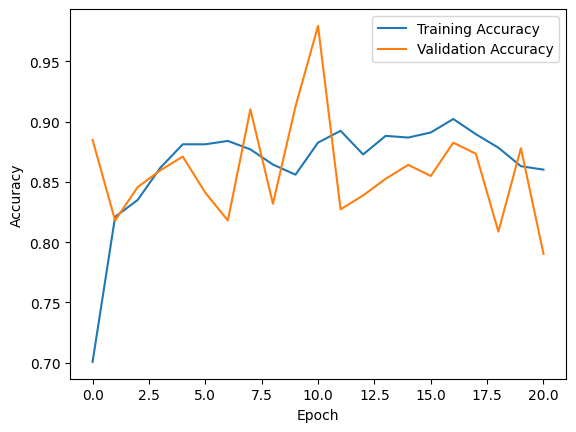

In [19]:
# Plot training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

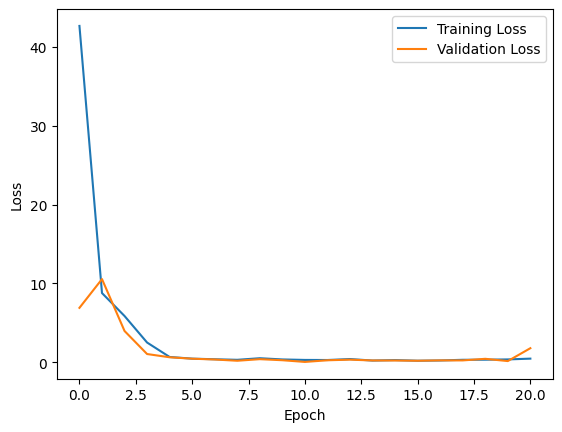

In [20]:
# Plot training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Testing the model
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.9:
        return "Real"
    else:
        return "Fake"

1/1 [==============================] - 0s 70ms/step


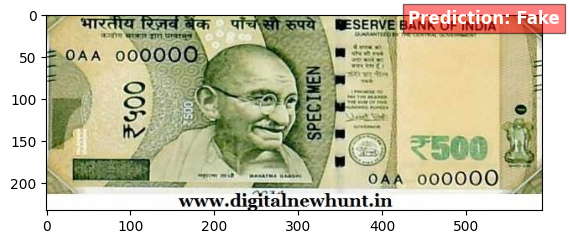

Prediction: Fake


In [39]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Training/Fake/Copy of Copy of Copy of Fake 3.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 0s 27ms/step


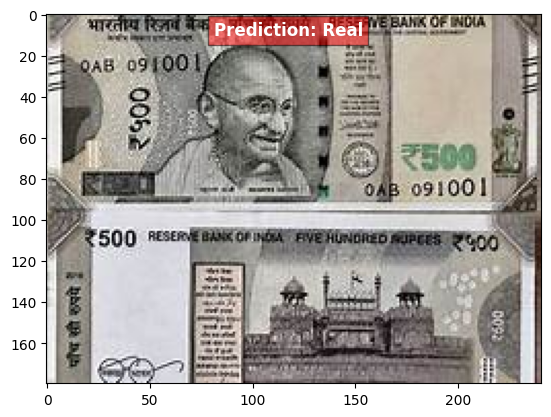

Prediction: Real


In [35]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Testing/Real/Real 2.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 0s 40ms/step


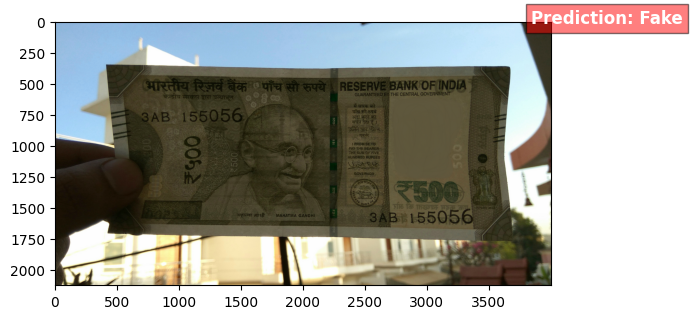

Prediction: Fake


In [40]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Training/Fake/Copy of Copy of Copy of Fake 6(6).jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 0s 24ms/step


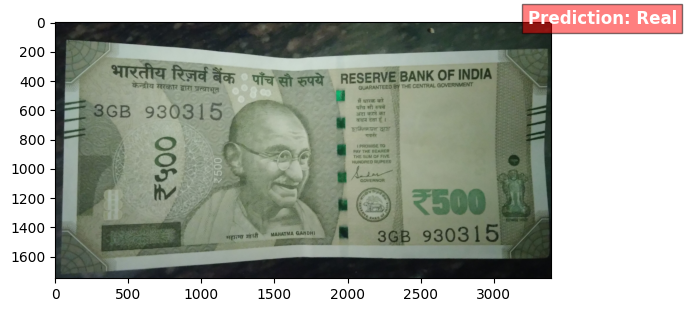

Prediction: Real


In [36]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset/Testing/Real/Real 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


In [ ]:
# Specify the image path
test_img_path = ""

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


In [ ]:
# Calculate overall accuracy of the model on the validation set.
overall_accuracy = finetune_model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)

In [ ]:
# Print overall accuracy.
print("Validation Accuracy:", overall_accuracy[1])

In [ ]:
# Calculate overall accuracy of the model on the training set.
overall_accuracy_training = finetune_model.evaluate_generator(generator=train_generator, steps=len(train_generator), verbose=1)

In [ ]:
# Print overall accuracy on training set.
print("Overall Accuracy on Training Set:", overall_accuracy_training[1])

In [ ]:
# Predict the whole validation set
validation_generator_predict = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                                      batch_size=batch_size, class_mode='binary', shuffle=False)
validation_generator_predict.reset()
predictions = finetune_model.predict(validation_generator_predict, steps=len(validation_generator_predict), verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = validation_generator_predict.classes

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Mean Squared Error
mse = mean_squared_error(true_classes, predicted_classes)
print(f"Mean Squared Error: {mse*100}")